# Исследование надёжности заёмщиков

Заказчик — кредитный отдел банка. Нужно разобраться, влияет ли семейное положение и количество детей клиента на факт погашения кредита в срок. Входные данные от банка — статистика о платёжеспособности клиентов.

Результаты исследования будут учтены при построении модели **кредитного скоринга** — специальной системы, которая оценивает способность потенциального заёмщика вернуть кредит банку.

## Шаг 1. Откройте файл с данными и изучите общую информацию

In [1]:
# импорт библиотеки pandas
import pandas as pd

In [2]:
# чтение файла с данными и сохранение в data
data = pd.read_csv('/datasets/data.csv')

In [3]:
# получение общей информации о данных в таблице data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
children            21525 non-null int64
days_employed       19351 non-null float64
dob_years           21525 non-null int64
education           21525 non-null object
education_id        21525 non-null int64
family_status       21525 non-null object
family_status_id    21525 non-null int64
gender              21525 non-null object
income_type         21525 non-null object
debt                21525 non-null int64
total_income        19351 non-null float64
purpose             21525 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


In [4]:
# посмотрим как выглядят данные
data.head()

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,-8437.673028,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья
1,1,-4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля
2,0,-5623.422610,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья
3,3,-4124.747207,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование
4,0,340266.072047,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу


**Вывод**

В таблице 12 столбцов. Тип данных в столбцах — int64, float64, object. По названию столбцов можно понять, что в таблице следущие данные:

* children - количество детей
* days_employed - дни трудового стажа
* dob_years - возраст
* education - образование
* education_id - категории образования
* family_status - семейное положение
* family_status_id - категории семейного положения
* gender - пол
* income_type - тип получения дохода
* debt - наличие кредита
* total_income - ежемесячный доход
* purpose - цель кредита


Количество значений в столбцах различается. Значит, в данных есть пропущенные значения. Нужно это устранить. Названия колонок единообразны.

Кроме того, из первых строк видно, что есть ошибки в значениях стажа. Далее рассмотрим, где еще есть ошибки.

## Шаг 2. Предобработка данных

### Обработка пропусков

In [5]:
# подсчёт пропусков
data.isna().sum()

children               0
days_employed       2174
dob_years              0
education              0
education_id           0
family_status          0
family_status_id       0
gender                 0
income_type            0
debt                   0
total_income        2174
purpose                0
dtype: int64

Учитывая, что в данных есть ошибки заменим пропуски медианными значениями. 

In [6]:
# выделим категории занятости
data['income_type'].value_counts()

сотрудник          11119
компаньон           5085
пенсионер           3856
госслужащий         1459
безработный            2
предприниматель        2
в декрете              1
студент                1
Name: income_type, dtype: int64

In [7]:
data['total_income'] = data['total_income'].fillna(data.groupby('income_type')['total_income'].transform('median'))
data['total_income'].isna().sum()

0

In [8]:
#в столбце стажа есть отрицательные значения, поменяем их на положительные
data[data['days_employed'] <= 0]['days_employed'].count()

data['days_employed'] = data['days_employed'].abs()

#заменим пропуски на медианные значения
data['days_employed']= data['days_employed'].fillna(data['days_employed'].median())

data['days_employed'].isna().sum()

0

In [9]:
data['years_employed'] = data['days_employed']/365

days_employed_error_index = []
days_employed_error = 0
for i in range(len(data['years_employed'])):
    if data.loc[i, 'years_employed'] >= (data.loc[i, 'dob_years']+14):
        days_employed_error +=1
        days_employed_error_index.append(i)
        
days_employed_error

3450

**Вывод**

Выявили и заполнили пропуски в столбцах со стажем и доходом. 


Вместе с тем, значения столбца со стажем требуют дополнительной корректировки. 3450 значений больше возможной продолжительности стажа. 

### Замена типа данных

In [10]:
#поменям тип данных для стажа, переведем вещественный тип данных на целочисленный. 
#Стаж в днях, правильней, если значения будут целыми.

data['days_employed'] = pd.to_numeric(data['days_employed'], errors = 'coerce')
data['days_employed'] = data['days_employed'].astype('int')

data['days_employed'].isna().sum()
data.info()

#сначала применим метод to_numeric() с параметром errors = 'coerce', 
#если возникнут ошибки, они будут заменины на Nan. А потом проверим есть ли пропуски.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 13 columns):
children            21525 non-null int64
days_employed       21525 non-null int64
dob_years           21525 non-null int64
education           21525 non-null object
education_id        21525 non-null int64
family_status       21525 non-null object
family_status_id    21525 non-null int64
gender              21525 non-null object
income_type         21525 non-null object
debt                21525 non-null int64
total_income        21525 non-null float64
purpose             21525 non-null object
years_employed      21525 non-null float64
dtypes: float64(2), int64(6), object(5)
memory usage: 2.1+ MB


In [11]:
data['years_employed'] = pd.to_numeric(data['years_employed'], errors = 'coerce')
data['years_employed'] = data['years_employed'].astype('int')

data['years_employed'].isna().sum()
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 13 columns):
children            21525 non-null int64
days_employed       21525 non-null int64
dob_years           21525 non-null int64
education           21525 non-null object
education_id        21525 non-null int64
family_status       21525 non-null object
family_status_id    21525 non-null int64
gender              21525 non-null object
income_type         21525 non-null object
debt                21525 non-null int64
total_income        21525 non-null float64
purpose             21525 non-null object
years_employed      21525 non-null int64
dtypes: float64(1), int64(7), object(5)
memory usage: 2.1+ MB


**Вывод**

В столбце «стаж в днях» перевели значение в целые числа, используя метод to numeric, который позволил в случае наличия ошибок , преобразовать их в Nan и не останавливать процесс замены типа данных. После применили метод astype. 

### Обработка дубликатов

In [12]:
# рассмотрим категирии образования
data['education'].value_counts()

среднее                13750
высшее                  4718
СРЕДНЕЕ                  772
Среднее                  711
неоконченное высшее      668
ВЫСШЕЕ                   274
Высшее                   268
начальное                250
Неоконченное высшее       47
НЕОКОНЧЕННОЕ ВЫСШЕЕ       29
НАЧАЛЬНОЕ                 17
Начальное                 15
ученая степень             4
УЧЕНАЯ СТЕПЕНЬ             1
Ученая степень             1
Name: education, dtype: int64

In [13]:
# для удаления дубликатов поправим регистр и проверим еще раз категории
data['education'] = data['education'].str.lower()
data['education'].value_counts()

среднее                15233
высшее                  5260
неоконченное высшее      744
начальное                282
ученая степень             6
Name: education, dtype: int64

In [14]:
# проверим явные дубликаты
data.duplicated().sum()

71

In [15]:
# удалим явные дубликаты и проверим
data = data.drop_duplicates().reset_index(drop=True)
data.duplicated().sum()

0

In [16]:
# оценим содержание data['purpose']
data['purpose'].value_counts()

свадьба                                   791
на проведение свадьбы                     768
сыграть свадьбу                           765
операции с недвижимостью                  675
покупка коммерческой недвижимости         661
операции с жильем                         652
покупка жилья для сдачи                   651
операции с коммерческой недвижимостью     650
жилье                                     646
покупка жилья                             646
покупка жилья для семьи                   638
строительство собственной недвижимости    635
недвижимость                              633
операции со своей недвижимостью           627
строительство жилой недвижимости          624
покупка недвижимости                      621
покупка своего жилья                      620
строительство недвижимости                619
ремонт жилью                              607
покупка жилой недвижимости                606
на покупку своего автомобиля              505
заняться высшим образованием      

In [17]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21454 entries, 0 to 21453
Data columns (total 13 columns):
children            21454 non-null int64
days_employed       21454 non-null int64
dob_years           21454 non-null int64
education           21454 non-null object
education_id        21454 non-null int64
family_status       21454 non-null object
family_status_id    21454 non-null int64
gender              21454 non-null object
income_type         21454 non-null object
debt                21454 non-null int64
total_income        21454 non-null float64
purpose             21454 non-null object
years_employed      21454 non-null int64
dtypes: float64(1), int64(7), object(5)
memory usage: 2.1+ MB


**Вывод**

Для обработки дубликатов в столбце с образованием применили метод приведения всех букв к строчному регистру и метод drop duplicates. Также переназначили индексы. Это позволило удалить 71 дублирующую строку и количество различных значений сократить с 15 до 5.

### Лемматизация

In [18]:
#импорт pymystem3 
from pymystem3 import Mystem
m = Mystem() 

In [19]:
# создадим новый столбец с леммами

def lemmas_purpose(purpose):
    lemmas = m.lemmatize(purpose)
    return lemmas

data['lemmas_purpose'] = data['purpose'].apply(lemmas_purpose)


In [20]:
# выделим категории для лемм целей кредита
data['lemmas_purpose'].value_counts()

[автомобиль, \n]                                          972
[свадьба, \n]                                             791
[на,  , проведение,  , свадьба, \n]                       768
[сыграть,  , свадьба, \n]                                 765
[операция,  , с,  , недвижимость, \n]                     675
[покупка,  , коммерческий,  , недвижимость, \n]           661
[операция,  , с,  , жилье, \n]                            652
[покупка,  , жилье,  , для,  , сдача, \n]                 651
[операция,  , с,  , коммерческий,  , недвижимость, \n]    650
[покупка,  , жилье, \n]                                   646
[жилье, \n]                                               646
[покупка,  , жилье,  , для,  , семья, \n]                 638
[строительство,  , собственный,  , недвижимость, \n]      635
[недвижимость, \n]                                        633
[операция,  , со,  , свой,  , недвижимость, \n]           627
[строительство,  , жилой,  , недвижимость, \n]            624
[покупка

In [21]:
# напишем фунукцию для создания нового столбца с категориями целей кредита
def lemmas_cat(purpose_lemmas):
    
        if 'образование' in purpose_lemmas:
            return 'образование'
        if 'автомобиль' in purpose_lemmas:
            return 'автомобиль'
        if ('жилье' or 'недвижимость') in purpose_lemmas:
            return 'недвижимость'
        if 'свадьба' in purpose_lemmas:
            return 'свадьба'
        
data['lemmas_cat'] = data['lemmas_purpose'].apply(lemmas_cat)
data['lemmas_cat'].head()

0    недвижимость
1      автомобиль
2    недвижимость
3     образование
4         свадьба
Name: lemmas_cat, dtype: object

In [22]:
# подсчитаем категории целей кредита
data['lemmas_cat'].value_counts()

недвижимость    4460
автомобиль      4306
образование     4013
свадьба         2324
Name: lemmas_cat, dtype: int64

**Вывод**

Среди изучаемых данных можно выделить 4 основные цели кредита: на недвижимость, автомобиль, образование и свадьбу. Причём на недвижимость кредит берут почти в 2 раза чаще, чем на свадьбу. 

### Категоризация данных

In [23]:
# выделим категории в зависимости от количества детей
data['children'].value_counts()

 0     14091
 1      4808
 2      2052
 3       330
 20       76
-1        47
 4        41
 5         9
Name: children, dtype: int64

In [24]:
# переведем отрицательные значения в положительные, а количество 20 заменим на 2

data['children'] = data['children'].abs()
# data.loc[data.loc[:, 'children'] == 20]['children'] = 2
data['children'] = data['children'].replace(20, 2)
# проверим выполнение 
data['children'].value_counts()

0    14091
1     4855
2     2128
3      330
4       41
5        9
Name: children, dtype: int64

In [25]:
# создадим таблицу для оценки количества наблюдений 
# и среднего значения категорий количества детей
data.groupby('children').agg({'debt':['count', 'mean']})

debt          
          count      mean
children                 
0         14091  0.075438
1          4855  0.091658
2          2128  0.094925
3           330  0.081818
4            41  0.097561
5             9  0.000000

In [26]:
# напишем функцию для создания столбца с категориями для наличия детей
def child(children_number):
    if children_number == 0:
        return 0
    return 1

data['children_id'] = data['children'].apply(child)

In [27]:
data['children_id'] = (data['children'] > 0).astype(int)

data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21454 entries, 0 to 21453
Data columns (total 16 columns):
children            21454 non-null int64
days_employed       21454 non-null int64
dob_years           21454 non-null int64
education           21454 non-null object
education_id        21454 non-null int64
family_status       21454 non-null object
family_status_id    21454 non-null int64
gender              21454 non-null object
income_type         21454 non-null object
debt                21454 non-null int64
total_income        21454 non-null float64
purpose             21454 non-null object
years_employed      21454 non-null int64
lemmas_purpose      21454 non-null object
lemmas_cat          15103 non-null object
children_id         21454 non-null int64
dtypes: float64(1), int64(8), object(7)
memory usage: 2.6+ MB


In [28]:
# создадим таблицу для оценки количества наблюдений 
# и среднего значения категорий наличия детей
data.groupby('children_id').agg({'debt':['count', 'mean']})

debt          
             count      mean
children_id                 
0            14091  0.075438
1             7363  0.092082

In [29]:
# создадим таблицу для оценки количества наблюдений 
# и среднего значения категорий семейного положения
data.groupby('family_status').agg({'debt':['count', 'mean']})

debt          
                       count      mean
family_status                         
Не женат / не замужем   2810  0.097509
в разводе               1195  0.071130
вдовец / вдова           959  0.065693
гражданский брак        4151  0.093471
женат / замужем        12339  0.075452

In [30]:
# напишем функцию для создания столбца с категориями для семейного положения
def family(status):
    if status == 'женат / замужем':
        return 1
#     if status == 'гражданский брак':
#         return 1
    return 0

data['status_id'] = data['family_status'].apply(family)

In [31]:
data['status_id'] = (data['children'] > 0).astype(int)

In [32]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21454 entries, 0 to 21453
Data columns (total 17 columns):
children            21454 non-null int64
days_employed       21454 non-null int64
dob_years           21454 non-null int64
education           21454 non-null object
education_id        21454 non-null int64
family_status       21454 non-null object
family_status_id    21454 non-null int64
gender              21454 non-null object
income_type         21454 non-null object
debt                21454 non-null int64
total_income        21454 non-null float64
purpose             21454 non-null object
years_employed      21454 non-null int64
lemmas_purpose      21454 non-null object
lemmas_cat          15103 non-null object
children_id         21454 non-null int64
status_id           21454 non-null int64
dtypes: float64(1), int64(9), object(7)
memory usage: 2.8+ MB


In [33]:
# создадим таблицу для оценки количества наблюдений 
# и среднего значения категорий для семейного положения
data.groupby('status_id').agg({'debt':['count', 'mean']})

debt          
           count      mean
status_id                 
0          14091  0.075438
1           7363  0.092082

In [34]:
# создадим таблицу для оценки значений ежемесячного дохода
data.agg({'total_income':['min', 'max', 'mean', 'median']})

,total_income
min,2.066726e+04
max,2.265604e+06
mean,1.653201e+05
median,1.425944e+05


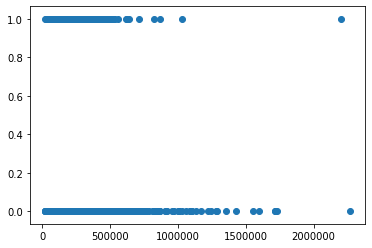

In [35]:
# посмотрим как распределяются значения
import matplotlib.pyplot as plt

plt.scatter(x= data['total_income'], y=data['debt'])
plt.show()


In [36]:
# посмотрим на 2 самых больших значения
data['total_income'].sort_values().tail(10)

11052    1.286281e+06
15234    1.350246e+06
18306    1.427934e+06
18321    1.551153e+06
17460    1.597613e+06
17137    1.711309e+06
20742    1.715018e+06
9159     1.726276e+06
19548    2.200852e+06
12390    2.265604e+06
Name: total_income, dtype: float64

In [37]:
# удалим 2 самых больших значения
data = data.drop([19548])
data = data.drop([12390])
data = data.reset_index(drop = True)


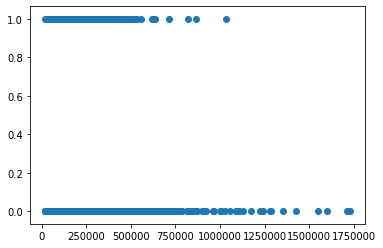

In [38]:
# проверим как распределяются значения 
plt.scatter(x= data['total_income'], y=data['debt'])
plt.show()

In [39]:
# напишем функцию для создания столбца с категориями для ежемесячного дохода
def income_id(income):
    if income <= 500000:
        return 1
    if income <= 1000000:
        return 2
    return 3

data['income_id'] = data['total_income'].apply(income_id)

In [40]:
# создадим таблицу для оценки количества наблюдений и среднего значения категорий 
data.groupby('income_id').agg({'debt':['count', 'mean']})

debt          
           count      mean
income_id                 
1          21232  0.081339
2            197  0.060914
3             23  0.043478

In [41]:
# создадим таблицу для оценки количества наблюдений 
# и среднего значения категорий  целей кредита
data.groupby('lemmas_cat').agg({'debt':['count', 'mean']})

debt          
             count      mean
lemmas_cat                  
автомобиль    4306  0.093590
недвижимость  4459  0.069074
образование   4013  0.092200
свадьба       2324  0.080034

**Вывод**

Выделили категории для столбцов с наличием детей, семейным статусом и доходом. Использовали метод agg для создания сводной таблицы по указанным значениям. Кроме того, для оценки распределения значений дохода, создали график. 

## Шаг 3. Ответьте на вопросы

- Есть ли зависимость между наличием детей и возвратом кредита в срок?

Если рассматривать наличие детей (вне зависимости от их количества), то , учитывая расчёты, смогли погасить кредит больше людей без детей  (92,5%). Для людей С детьми - этот показатель чуть ниже - 90,8%. Но количество наблюдений в данной выборке для людей с детьми почти в 2 раза меньше. Возможно результаты были бы другими. 

Если рассматривать в отдельности показатели по количеству детей, то однозначного вывод сделать не получается из-за того, что различаются количества наблюдений. Так, например, для семьи с 5 детьми кредит был погашён во всех случаях, а с 4ми в 91%.



**Вывод**

Считаю, что однозначно утверждать , что зависимость существует, нельзя. По данному набору наблюдений можно заметить, что смогли погасить кредит больше людей без детей. 


- Есть ли зависимость между семейным положением и возвратом кредита в срок?

В официальном браке смогли во время погасить кредит в 92,5%, тогда как в остальных случаях погашение кредита составило 91,2%. Интересно, что больше всего погасили кредит вдовцы/вдовы - в 93,4%, а холостые люди - в 90,3%.


**Вывод**

Зависимость погашения кредита от семейного положения не очевидна. Разница вероятности погашения кредита между разными категориями 2-3%. 

- Есть ли зависимость между уровнем дохода и возвратом кредита в срок?

Разделив ежемесячные доходы на 3 категории: до 500 тыс. ₽, до 1 млн. ₽ и выше , процент погашения кредита повышается с увеличением дохода: 91,9%, 93,9%, 95,7% соответственно 

**Вывод**

С увеличением дохода процент погашения кредита повышается в пределах 4%

- Как разные цели кредита влияют на его возврат в срок?

В зависимости от целей кредита процент погашения отличается, но в пределах 3%. Автокредиты погашали реже всего в 90,7%, почти также как и кредиты на образование (90,7%). 

**Вывод**

Кредит на цели, связанные с недвижимостью (покупка, строительство, ремонт и др.), погашается в большем числе случаев.  

## Шаг 4. Общий вывод

В рамках данного проекта изучили массив данных с информациях о заёмщиках. Обработали данные: заполнили пропуски, удалили дубликаты, выделили категории. Данные операции позволили сделать вывод о зависимости отдельных условий на погашение кредита. В частности, наибольшее влияние на погошенин кредита имеет доход , а не количество детей и семейный статус.
